In [6]:
fl_app = 'nvflare-sverepec_spolu-sim'
model_name = 'myModel3'

In [7]:
import keras
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf

exec('import %s' % model_name)

nvflare_app_dir = os.path.join('..', fl_app)
data_dir = os.path.join(nvflare_app_dir, 'data')
app_server_dir = os.path.join(nvflare_app_dir, 'workspace', 'simulate_job', 'app_server')

sys.path.append(nvflare_app_dir)

from IPython.display import JSON, HTML
from nvflare.fuel.utils import fobs
from nvflare.app_common.abstract.model import ModelLearnable, make_model_learnable
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

summary_line_length = 128

## load global model

In [9]:
model_filename = os.path.join(app_server_dir, 'model.h5')
m = tf.keras.models.load_model(model_filename)
m.summary(line_length=summary_line_length, expand_nested=True)

Model: "model_52"
________________________________________________________________________________________________________________________________
 Layer (type)                                            Output Shape                                       Param #             
 input_53 (InputLayer)                                   [(None, 186)]                                      0                   
                                                                                                                                
 fullyConnectedLayer1_ (Dense)                           (None, 28)                                         5236                
                                                                                                                                
 batchNormalizationLayer_ (BatchNormalization)           (None, 28)                                         112                 
                                                                               

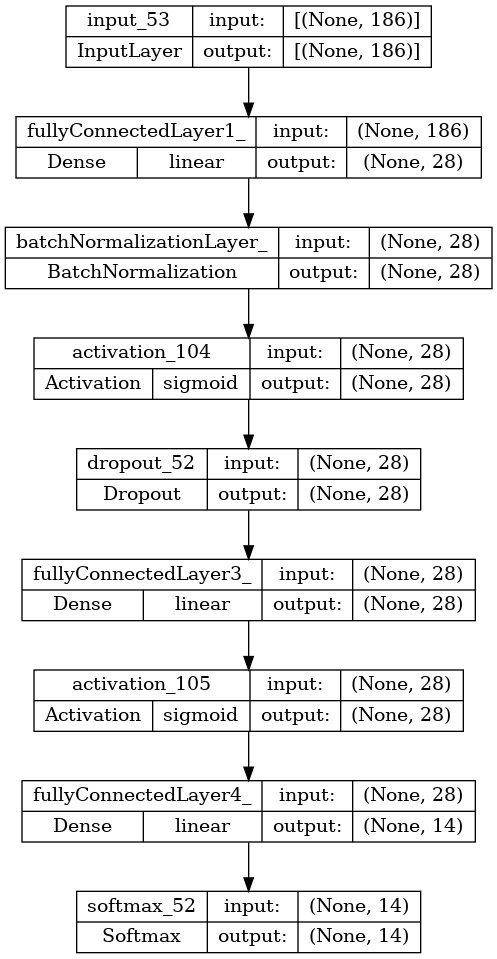

In [10]:
tf.keras.utils.plot_model(
    m,
    expand_nested=True,
    show_shapes=True,
    show_layer_activations=True
)

## load label encoder

In [11]:
label_encoder_filename = os.path.join(data_dir, 'encoder-DRUH_DR.npy')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load(label_encoder_filename, allow_pickle=True)

## load site data

In [12]:
site = 1
filename_test = os.path.join(data_dir, 'site-%s' % site, 'train.csv')
df_test = pd.read_csv(filename_test)
display(df_test)

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10,DRUH_DR
0,0.000723,0.000680,0.000809,0.000789,0.000611,0.000702,0.000853,0.000752,0.000561,0.000924,...,0.002536,0.002402,0.002225,0.002478,0.002655,0.003029,0.003016,0.002345,0.002511,10
1,0.001007,0.000957,0.001059,0.000922,0.001012,0.000917,0.000994,0.001020,0.001001,0.000937,...,0.004817,0.004137,0.004540,0.005040,0.005634,0.005582,0.006649,0.005164,0.006423,10
2,0.001916,0.002165,0.002794,0.002754,0.002498,0.002895,0.002747,0.002878,0.002416,0.002972,...,0.043110,0.040226,0.039312,0.040915,0.046393,0.049094,0.050635,0.049453,0.052009,2
3,0.002113,0.002115,0.001980,0.002047,0.002331,0.002273,0.002616,0.002359,0.002176,0.002652,...,0.027066,0.025726,0.024522,0.026182,0.028137,0.031342,0.028951,0.032099,0.031233,10
4,0.001583,0.001443,0.001607,0.001558,0.001464,0.001675,0.001673,0.001378,0.001482,0.001775,...,0.010887,0.009931,0.009676,0.011033,0.012535,0.012114,0.012736,0.012266,0.013554,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5896,0.001357,0.001484,0.001460,0.001682,0.001498,0.001641,0.001585,0.001411,0.001341,0.001568,...,0.008260,0.008142,0.008400,0.008742,0.008910,0.009070,0.009395,0.009864,0.010137,10
5897,0.002801,0.002621,0.003225,0.002983,0.003674,0.003131,0.003337,0.003514,0.003132,0.003832,...,0.041057,0.037258,0.037696,0.040465,0.043956,0.044762,0.046325,0.046831,0.048426,2
5898,0.000753,0.000981,0.001101,0.000968,0.000933,0.000933,0.000921,0.000897,0.000686,0.000883,...,0.003345,0.003357,0.003286,0.003516,0.004034,0.003434,0.004215,0.004569,0.004457,10
5899,0.004088,0.004136,0.004388,0.004522,0.005047,0.004928,0.004991,0.004667,0.004537,0.005606,...,0.041475,0.038538,0.039111,0.041525,0.043982,0.047722,0.047762,0.047684,0.050159,13


## test model on the loaded site data

In [13]:
df = df_test

X = df[df.columns.drop(df.DRUH_DR.name)]

Y = df[df.DRUH_DR.name]
Y = label_encoder.inverse_transform(Y)
Y = pd.DataFrame(Y, columns=['Y'])

Y_pred = m.predict(X)
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred = label_encoder.inverse_transform(Y_pred)
Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])

display(pd.concat([Y, Y_pred], axis=1))

185/185 [==============================] - 1s 2ms/step


,Y,Y_pred
0,SM,SM
1,SM,SM
2,CR,CR
3,SM,SM
4,SM,SM
...,...,...
5896,SM,SM
5897,CR,CR
5898,SM,SM
5899,ÄŤremcha,CR


## confusion matrix

In [22]:
conf_matrix = pd.DataFrame(confusion_matrix(Y, Y_pred, labels=label_encoder.classes_, normalize='pred'))
conf_matrix.rename(columns=lambda x: label_encoder.inverse_transform([x])[0], inplace=True)
conf_matrix.rename(index=lambda x: label_encoder.inverse_transform([x])[0], inplace=True)
conf_matrix.set_index(pd.MultiIndex.from_product([['truth'], conf_matrix.index]), inplace=True)
conf_matrix.columns = pd.MultiIndex.from_product([['prediction'], conf_matrix.columns])


def highlight_cells(val):
    color = 'lightgreen' if val > 0.8 else ''
    return 'background-color: {}'.format(color)

conf_matrix

prediction                                                    \
                       BO   BR        CR        DL   DZ   HB   JH        JP   
truth BO              0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      BR              0.0  0.0  0.003263  0.004338  0.0  0.0  0.0  0.033898   
      CR              0.0  0.0  0.934747  0.000000  1.0  0.0  0.0  0.000000   
      DL              0.0  0.0  0.016313  0.906725  0.0  0.0  0.0  0.000000   
      DZ              0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      HB              0.0  1.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      JH              0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      JP              0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.949153   
      LM              0.0  0.0  0.000000  0.071584  0.0  0.0  0.0  0.008475   
      OS              0.0  0.0  0.014682  0.010846  0.0  0.0  0.0  0.000000   
      SM              0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.000000   
      VR              0.0  0.0  0.000000  0.004338  0.0  0.0  0.0  0.000000   
      lieska          0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.008475   
      ÄŤremcha        0.0  0.0  0.030995  0.002169  0.0  0.0  0.0  0.000000   

                                                                        
                      LM        OS        SM        VR lieska ÄŤremcha  
truth BO        0.000000  0.000000  0.000598  0.000000   0.00      0.0  
      BR        0.000000  0.007475  0.030493  0.085106   0.02      0.0  
      CR        0.000000  0.012458  0.001495  0.000000   0.02      0.0  
      DL        0.000000  0.024086  0.001495  0.170213   0.04      0.0  
      DZ        0.000000  0.012458  0.000598  0.191489   0.08      0.0  
      HB        0.000000  0.000831  0.000897  0.106383   0.00      0.0  
      JH        0.000000  0.000000  0.002691  0.000000   0.00      0.0  
      JP        0.000000  0.000000  0.000000  0.000000   0.04      0.0  
      LM        0.981818  0.000000  0.000000  0.000000   0.04      0.0  
      OS        0.000000  0.890365  0.013154  0.042553   0.00      0.0  
      SM        0.000000  0.037375  0.941704  0.042553   0.00      0.0  
      VR        0.000000  0.014120  0.006876  0.297872   0.00      0.0  
      lieska    0.018182  0.000831  0.000000  0.063830   0.74      0.0  
      ÄŤremcha  0.000000  0.000000  0.000000  0.000000   0.02      1.0